# 5.2 그리드 서치

앞에서 모델의 일반화 성능을 측정하는 법을 배웠고, 이제 다음 단계로 매개변수를 튜닝하여 일반화 성능을 개선해보자. 2장과 3장에서 scikit-learn의 여러 알고리즘의 매개변수 설정에 대해 이야기했는데 매개변수를 조정하기 전에 그 매개변수의 의미를 이해하는 것이 중요하다. 모델에서 중요한 매개변수의 (일반화 성능을 최대로 높여주는) 값을 찾는 일은 어려운 작업이지만, 모든 모델과 데이터셋에서 해야 하는 필수적인 일이다. 많이 하는 작업이므로 scikit-learn에는 이를 위한 메서드가 준비되어 있다. 가장 널리 사용하는 방법은 **그리드 서치**(grid search)로서 관심있는 매개변수들을 대상으로 가능한 모든 조합을 시도해보는 것이다.

SVC 파이썬 클래스에 구현된 RBF(radial basis function) 커널 SVM을 사용해보자. 2장에서 본 것처럼 커널의 폭에 해당하는 gamma와 규제 매개변수 C가 중요하다. 매개변수 C와 gamma에 0.001, 0.01, 0.1, 1, 10, 100 값을 적용해보자. C와 gamma의 설정값이 각각 6개씩이니 조합의 수는 총 36개이다.

### 5.2.1 간단한 그리드 서치

두 매개변수 조합에 대해 분류기를 학습시키고 평가하는 간단한 그리드 서치를 for 문을 사용해 만들 수 있다.

In [1]:
# 간단한 그리드 서치 구현
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split as tts
from sklearn.datasets import load_iris

iris = load_iris()

X_train, X_test, y_train, y_test = tts(iris.data, iris.target, random_state=0)
print("훈련 세트의 크기: {}   테스트 세트의 크기: {}".format(X_train.shape[0], X_test.shape[0]))

best_score = 0

for gamma in [0.001, 0.01, 0.1, 1, 10, 100]:
    for C in [0.001, 0.01, 0.1, 1, 10, 100]:
        # 매개변수의 각 조합에 대해 SVC를 훈련시킨다.
        svm = SVC(gamma=gamma, C=C)
        svm.fit(X_train, y_train)
        # 테스트 세트로 SVC를 평가한다.
        score = svm.score(X_test, y_test)
        # 점수가 더 높으면 매개변수와 함께 기록한다.
        if score > best_score:
            best_score = score
            best_parameters = {'C':C, 'gamma':gamma}
            
print("최고 점수: {:.2f}".format(best_score))
print("최적 매개변수:", best_parameters)

훈련 세트의 크기: 112   테스트 세트의 크기: 38
최고 점수: 0.97
최적 매개변수: {'C': 100, 'gamma': 0.001}


### 5.2.2 매개변수 과대적합과 검증 세트

앞의 결과를 보면 이 데이터셋에서 모델 정확도가 97%라고 보고할 수 있다. 하지만 이런 주장은 다음과 같은 이유로 매우 낙관적인 (혹은 잘못된) 것일 수 있다. 여러 가지 매개변수 값으로 많이 시도해보고 테스트 세트 정확도가 가장 높은 조합을 선택했다. 하지만 이 정확도는 새로운 데이터에까지 이어지지 않을 수 있다. 매개변수를 조정하기 위해 테스트 세트를 이미 사용했기 때문에 모델이 얼마나 좋은지 평가하는 데는 더 이상 사용할 수 없다. 맨 처음 데이터를 훈련 세트와 테스트 세트로 나눈 이유와 같다. 즉, 평가를 위해서는 모델을 만들 때 사용하지 않은 독립된 데이터셋이 필요하다.

데이터를 다시 나눠서 세개의 세트로 만들어 이 문제를 해결할 수 있다. 훈련 세트로는 모델을 만들고, 검증 (또는 개발) 세트로는 모델의 매개변수를 선택하고, 테스트 세트로는 선택된 매개변수의 성능을 평가한다.

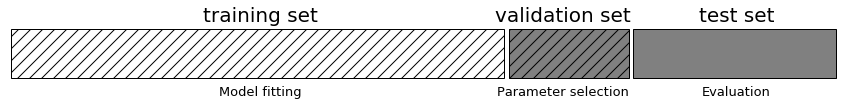

In [3]:
import mglearn

mglearn.plots.plot_threefold_split()

검증 세트를 사용해 최적의 매개변수를 선택한 후, 그 매개변수에서 훈련 세트와 검증 세트 데이터를 모두 이용해 모델을 다시 만든다. 이렇게 하는 이유는 모델을 만들 때 가능한 많은 데이터를 이용하기 위해서이다. 

In [4]:
from sklearn.svm import SVC
# 데이터를 훈련+검증 세트 그리고 테스트 세트로 분할
X_trainval, X_test, y_trainval, y_test = tts(iris.data, iris.target, random_state=0)
# 훈련+검증 세트를 훈련 세트와 검증 세트로 분할
X_train, X_valid, y_train, y_valid = tts(X_trainval, y_trainval, random_state=1)

print("훈련 세트의 크기: {}  검증 세트의 크기: {}  테스트 세트의 크기: {}\n".format(X_train.shape[0],X_valid.shape[0],X_test.shape[0]))

best_score = 0
for gamma in [0.001, 0.01, 0.1, 1, 10, 100]:
    for C in [0.001, 0.01, 0.1, 1, 10, 100]:
        svm = SVC(gamma=gamma, C=C)
        svm.fit(X_train, y_train)
        score = svm.score(X_valid, y_valid)
        if score > best_score:
            best_score = score
            best_parameters = {'C':C, 'gamma':gamma}
                
svm = SVC(**best_parameters)
svm.fit(X_trainval, y_trainval)
test_score = svm.score(X_test, y_test)
print("검증 세트에서 최고 점수: {:.2f}".format(best_score))
print("최적 매개변수: ", best_parameters)
print("최적 매개변수에서 테스트 세트 점수: {:.2f}".format(test_score))

훈련 세트의 크기: 84  검증 세트의 크기: 28  테스트 세트의 크기: 38

검증 세트에서 최고 점수: 0.96
최적 매개변수:  {'C': 10, 'gamma': 0.001}
최적 매개변수에서 테스트 세트 점수: 0.92


검증 세트에서 최고 점수는 96%이다. 전보다 조금 낮아졌는데 아마도 모델을 훈련할 때 사용한 데이터가 적어졌기 때문이다. 하지만 테스트 세트 점수(실제 이 모델이 얼마나 잘 일반화됐는지 알려주는 점수)는 훨씬 낮은 92%이다. 따라서 앞서 예상한 97%가 아니라, 새로운 데이터에 대해 92%만 정확하게 분류한다고 말할 수 있다.

훈련 세트, 검증 세트, 테스트 세트의 구분은 실제 머신러닝 알고리즘을 적용하는 데 아주 중요하다. 테스트 세트 정확도에 기초해 어떤 선택을 했다면 테스트 세트의 정보를 모델에 누설한 것이다. 그렇기 때문에 최종 평가에만 사용하도록 테스트 세트를 분리해 유지하는 것이 중요하다. (데이터 탐색을 위한 시각화를 포함해서) 모든 탐색적 분석과 모델 선택을 위해서는 훈련 세트와 검증 세트를 사용하는 것을 권장하며, 마지막 평가를 위해 테스트 세트를 보관하는 것이 좋다. 정확하게 말하면 테스트 세트로 둘 이상의 모델을 평가해서 그중 더 나은 하나를 선택하는 것은 모델의 정확도를 매우 낙관적으로 추정하는 행위이다.

### 5.2.3 교차 검증을 사용한 그리드 서치

데이터를 훈련 세트, 검증 세트, 테스트 세트로 나누는 방법은 잘 작동하고 널리 사용되지만, 데이터를 나누는 방법에 매우 민감하다. 이전 코드의 출력에서는 C: 10, gamma: 0.001을 최적의 매개변수로 선택했지만. 앞 절의 코드에서는 C:100, gamma: 0.001을 최적으로 선택했다. 일반화 성능을 더 잘 평가하려면 훈련 세트와 검증 세트를 한 번만 나누지 않고, 교차 검증을 사용해서 각 매개변수 조합의 성능을 평가할 수 있다. 이 방식은 다음 코드와 같다.

In [5]:
import numpy as np
from sklearn.model_selection import cross_val_score

best_score = 0

for gamma in [0.001, 0.01, 0.1, 1, 10, 100]:
    for C in [0.001, 0.01, 0.1, 1, 10, 100]:
        svm = SVC(gamma=gamma, C=C)
        scores = cross_val_score(svm, X_trainval, y_trainval, cv=5)
        score = np.mean(scores)
        if score > best_score :
            best_score = score
            best_parameters = {"C": C, "gamma": gamma}
            
svm = SVC(**best_parameters)
svm.fit(X_trainval, y_trainval)

SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

5-겹 교차 검증으로 C와 gamma 걸정에 대한 SVM의 정확도를 평가하려면 36 X 5 = 180개의 모델을 만들어야 한다. 예상하듯이, 교차 검증의 단점은 이 모델들을 모두 학습시키는 데 걸리는 시간이다.

C:\Users\NT500R\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


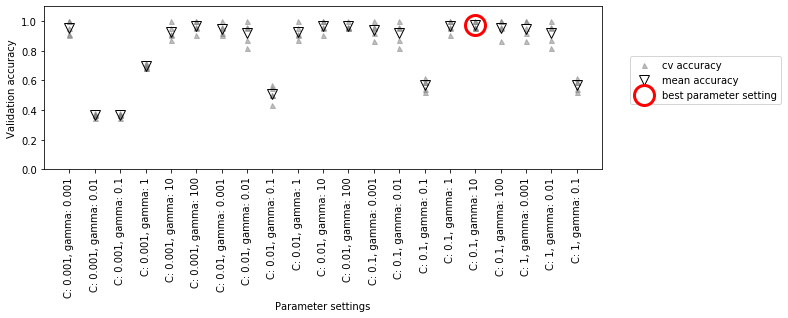

In [6]:
mglearn.plots.plot_cross_val_selection()

각 매개변수 설정마다 교차 검증 분할에 한 개씩, 모두 다섯 개의 값을 계산한다. 교차 검증 정확도 평균이 가장 높은 매개변수를 동그라미로 표시했다.

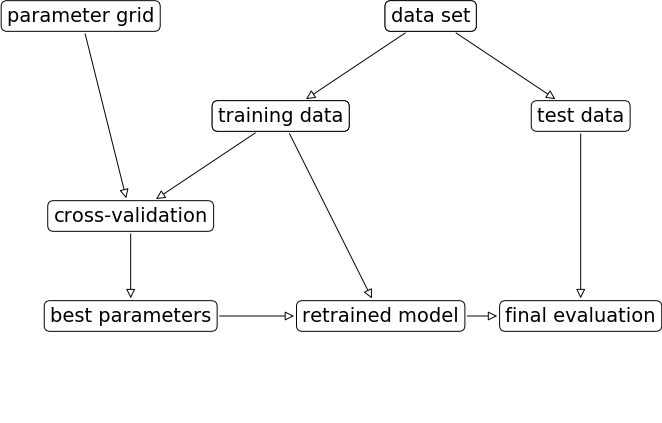

In [7]:
mglearn.plots.plot_grid_search_overview()

교차 검증을 사용한 그리드 서치를 매개변수 조정 방법으로 널리 사용하기 때문에 scikit-learn은 추정기 형태로 구현된 GridSearchCV를 사용하려면 먼저 딕셔너리 형태로 검색 대상 매개변수를 지정해야 한다. 그러면 GridSearchCV는 필요한 모든 모델을 학습시킨다. 딕셔너리의 키는 조정하고자 하는 매개변수 이름(모델 생성 시 지정할 것들, 이 경우에는 C와 gamma)이고, 값은 탐색할 매개변수의 설정값이다. C와 gamma에 0.001, 0.01, 0.1, 1, 10, 100 값을 시도하려면 다음과 같은 딕셔너리를 만든다.

In [8]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100], 'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}
print("매개변수 그리드: \n", param_grid)

매개변수 그리드: 
 {'C': [0.001, 0.01, 0.1, 1, 10, 100], 'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}


In [9]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
grid_search = GridSearchCV(SVC(), param_grid, cv=5, return_train_score=True)

앞서 훈련 세트와 검증 세트로 한 번 분리했던 것과 달리 GridSearchCV는 교차 검증을 사용한다. 그러나 매개변수가 과대적합되는 것을 피하려면 여기에서도 데이터를 훈련 세트와 테스트 세트로 나눠야 한다.

In [10]:
X_train, X_test, y_train, y_test = tts(iris.data, iris.target, random_state=0)

In [11]:
grid_search.fit(X_train, y_train)

C:\Users\NT500R\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=None,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'gamma': [0.001, 0.01, 0.1, 1, 10, 100]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring=None, verbose=0)

GridSearchCV 객체의 fit 메서드는 최적의 매개변수를 찾는 일뿐만 아니라, 교차 검증 성능이 가장 좋은 매개변수로 전체 훈련 데이터셋에 대해 새로운 모델을 자동으로 만든다. 그래서 fit 메서드에서 처리하는 일은 앞서 for문과 대등하다. GridSearchCV는 전체 데이터로 학습한 모델에 접근할 수 있도록 predict와 score 메서드를 제공한다. 찾은 최적 매개변수로 일반화 성능을 평가하려면 테스트 세트를 매개변수로 넘겨 score 메서드를 호출하면 된다. 

In [12]:
print("테스트 세트 점수: {:.2f}".format(grid_search.score(X_test, y_test)))

테스트 세트 점수: 0.97


교차 검증으로 매개변수를 선택하니 테스트 세트 정확도가 97%인 모델을 얻었다. 여기서 중요한 것은 매개변수를 선택하는 데 테스트 세트를 사용하지 않았다는 것이다. 선택한 매개변수는 best_params_ 속성에 담겨 있으며 최상의 교차 검증 정확도는 (이 매개변수 설정으로 각 분할에서 얻은 정확도의 평균) best_score_에 저장된어 있다.

In [13]:
print("최적 매개변수:", grid_search.best_params_)
print("최고 교차 검증 점수: {:.2f}".format(grid_search.best_score_))

최적 매개변수: {'C': 100, 'gamma': 0.01}
최고 교차 검증 점수: 0.97


**CAUTION** : 테스트 세트로 score 메서드에서 계산하는 모델의 일반화 성능과 best_score_를 혼동해서는 안된다. score 메서드는(또는 predict 메서드의 결과는) 전체 훈련 세트에서 학습한 모델에 대한 것이다. best_score_ 속성에는 훈련 세트에서 수행한 교차 검증의 평균 정확도가 저장된다.***

가끔은 만들어진 실제 모델에 직접 접근해야 할 때가 있다. 예를 들면 계수나 특성 중요도를 사려보려고 할 때이다. 최적의 매개변수에서 전체 훈련 세트를 사용하여 학습한 모델은 best_estimator_ 속성에서 얻을 수 있다.

In [14]:
print("최고 성능 모델:\n", grid_search.best_estimator_)

최고 성능 모델:
 SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)


### 교차 검증 결과 분석

교차 검증의 결과를 시각화하면 검색 대상 매개변수가 모델의 일반화에 영향을 얼마나 주는지 이해하는 데 도움이 된다. 그리드 서치는 연상 비용이 매우 크므로 비교적 간격을 넓게 하여 적은 수의 그리드로 시작하는 것이 좋다. 그런 다음 교차 검증된 그리드 서치의 결과를 분석하여 검색을 확장해나갈 수 있다. 그리드 서치의 결과는 검색과 관련한 여러 정보가 함께 저장되어 있는 딕셔너리인 cv_results_ 속성에 담겨 있다. 다음 결과에서 볼 수 있듯이 이 속성에는 상세 정보가 많이 들어 있으므로 pandas의 DataFrame으로 변환해서 보는 것이 좋다.

In [15]:
import pandas as pd
pd.set_option('display.max_columns', None)
# DataFrame으로 변환
results = pd.DataFrame(grid_search.cv_results_)
# 처음 다섯 개 행을 출력한다.
display(np.transpose(results.head()))

,0,1,2,3,4
mean_fit_time,0.00119681,0.000997734,0.000797892,0.000799084,0.000598001
std_fit_time,0.000399733,5.91739e-07,0.000398946,0.000399544,0.000488268
mean_score_time,0.000598526,0.00059824,0.000199604,0.000199461,0.000399685
std_score_time,0.000488694,0.000797534,0.000399208,0.000398922,0.000489513
param_C,0.001,0.001,0.001,0.001,0.001
param_gamma,0.001,0.01,0.1,1,10
params,"{'C': 0.001, 'gamma': 0.001}","{'C': 0.001, 'gamma': 0.01}","{'C': 0.001, 'gamma': 0.1}","{'C': 0.001, 'gamma': 1}","{'C': 0.001, 'gamma': 10}"
split0_test_score,0.375,0.375,0.375,0.375,0.375
split1_test_score,0.347826,0.347826,0.347826,0.347826,0.347826
split2_test_score,0.363636,0.363636,0.363636,0.363636,0.363636


results의 행 하나는 특정한 하나의 매개변수 설정에 대응한다. 각 설정에 대해 교차 검증의 모든 분할의 평균값, 표준편차를 포함한 결과가 기록되어 있다. 검색 대상 매개변수 그리드가 2차원이므로 (C와 gamma), 히트맵으로 시각화하기가 좋다. 먼저 교차 검증의 평균을 뽑아서 C와 gamma 축에 맞도록 배열 차원을 바꾼다.

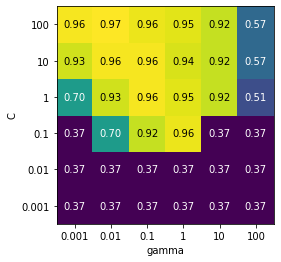

In [17]:
scores = np.array(results.mean_test_score).reshape(6,6)

# 교차 검증 평균 점수 히트맵 그래프
mglearn.tools.heatmap(scores, xlabel='gamma', xticklabels=param_grid['gamma'],
                     ylabel='C', yticklabels=param_grid['C'], cmap='viridis')

히트맵의 각 포인트는 특정 매개변수 설정에 대한 교차 검증 실행을 나타낸다. 교차 검증의 정확도가 높으면 밝은 색으로, 낮으면 어두운 색으로 나타냈다. 그래프를 보면 SVC가 매개변수 설정에 매우 민감함을 알 수 있다. 많은 매개변수 설정에서 40% 부근의 낮은 정확도를 내고 있지만 어떤 설정에서는 96% 이상을 만들었다. 이 그래프에서 몇 가지 정보를 얻을 수 있다. 먼저 높은 성능을 얻으려면 매개변수 조정이 매우 중요하다는 점이다. 두 매개변수(C와 gamma)가 매우 중요하며 어떻게 조정하는지에 따라 정확도가 40%에서 96%까지 차이가 난다. 또 선택한 매개변수 그리드의 범위에서 결괏값이 크게 변하고 있다. 즉, 각 매개변수의 최적값이 그래프 끝에 놓이지 않도록 매개변수의 범위가 충분히 넓다는 점이 중요하다.

검색 범위가 적절하게 선택되지 않아서 바람직하지 못한 결과를 내는 그래프 예를 보자.

C:\Users\NT500R\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\NT500R\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\NT500R\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


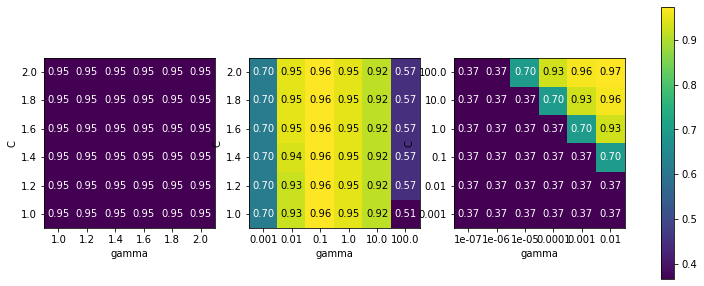

In [19]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1,3, figsize=(13,5))

param_grid_linear = {'C' : np.linspace(1, 2, 6),
                    'gamma' : np.linspace(1, 2, 6)}

param_grid_one_log = {'C': np.linspace(1,2,6),
                     'gamma': np.logspace(-3,2,6)}

param_grid_range = {'C':np.logspace(-3,2,6),
                   'gamma':np.logspace(-7,-2,6)}

for param_grid, ax in zip([param_grid_linear, param_grid_one_log, param_grid_range], axes):
    grid_search = GridSearchCV(SVC(), param_grid, cv=5)
    grid_search.fit(X_train, y_train)
    scores = grid_search.cv_results_['mean_test_score'].reshape(6,6)
    
    # 교차 검증 평균 점수의 히트맵 그래프
    scores_image = mglearn.tools.heatmap(scores, xlabel='gamma', ylabel='C', xticklabels=param_grid['gamma'],
                                        yticklabels=param_grid['C'], cmap='viridis', ax=ax)
    
plt.colorbar(scores_image, ax=axes.tolist())

첫 번째 그래프는 점수 변화가 거의 없어서 전체 매개변수 그리드가 같은 색이다. 이런 결과는 매개변수 C와 gamma의 스케일과 범위가 부적절할 때 발생한다. 그러나 매개변수 설정이 바뀌어도 정확도에 아무런 변화가 없다면, 그 매개변수가 전혀 중요하지 않은 것일 수도 있다. 처음에는 매우 극단적인 값을 적용해보고, 매개변수를 바꿔가며 정확도가 변하는지 살펴보는 것이 좋다.

두 번째 그래프는 세로 띠 형태를 보인다. 이는 gamma 매개변수만 정확도에 영향을 준다는 뜻이다. 즉 gamma 매개변수는 적절한 범위를 탐색하고 있지만, C 매개변수는 그렇지 못하든지, 아니면 중요한 매개변수가 아닐 수도 있다. 

세 번째 그래프는 C와 gamma 둘 모두에 따라 값이 변했다. 하지만 그래프의 왼쪽 아래 영역에서는 아무런 변화가 없다. 아마도 다음 번 검색 땐 매개변수 그리드에서 매우 작은 단위는 제외될 것이다. 최적치가 그래프의 경계에 있으니 이 경계 너머에 더 나은 값이 있다고 생각할 수 있다. 그러니 이 영역이 포함되도록 매개변수 검색 범위를 바꿔줘야 한다.

교차 검증 점수를 토대로 매개변수 그리드를 튜닝하는 것은 아주 안전한 방법이며, 매개변수들의 중요도를 확인하는 데도 좋다. 그러나 최종 테스트 세트를 대상으로 여러 매개변수 범위를 테스트해서는 안 된다. 앞서 이야기했지만, 테스트 세트 평가는 사용할 모델이 정확히 결정되고 나서 딱 한 번만 해야 한다.

### 비대칭 매개변수 그리드 탐색

어떤 경우에는 모든 매개변수의 조하바에 대해 GridSearchCV를 수행하는 것이 좋은 생각이 아닐 수 있다. 예를 들어 SVC는 kernel 매개변수를 가지고 있는데 어떤 커널을 사용하는지에 따라 관련 있는 매개변수들이 결정된다. kernel='linear'이면 선형 모델이고 C 매개변수만 사용한다. kernel='rbf'이면 C와 gamma를 모두 사용한다(하지만 degree 같은 다른 매개변수는 사용하지 않는다). 이런 경우에 C, gamma, kernel 매개변수의 모든 조합을 조사하는 것은 맞지 않다. kernel='linear'이면 gamma를 사용하지 않으므로 gamma의 값에 대해 조사하는 것은 시간 낭비이다. 이런 조건부 매개변수 조합을 적용하려면 GridSearchCV에 전달할 param_grid를 딕셔너리의 리스트로 만들어 주면 된다. 리스트에 있는 각 딕셔너리는 독립적인 그리드로 적용된다. kernel을 포함한 매개변수 그리드의 예는 다음과 같다.

In [20]:
param_grid = [{'kernel' : ['rbf'],
              'C' : [0.001, 0.01, 0.1, 1, 10, 100],
              'gamma' : [0.001, 0.01, 0.1, 1, 10, 100]},
             {'kernel' : ['linear'],
             'C' : [0.001, 0.01, 0.1, 1, 10, 100]}]

print("그리드 목록:\n", param_grid)

그리드 목록:
 [{'kernel': ['rbf'], 'C': [0.001, 0.01, 0.1, 1, 10, 100], 'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}, {'kernel': ['linear'], 'C': [0.001, 0.01, 0.1, 1, 10, 100]}]


첫 번째 그리드에서 kernel 매개변수는 rbf로 고정되고(kernel 항목의 리스트 길이가 1이다), C와 gamma 두 매개변수는 비뀐다. 두 번째 그리드에서 kernel 매개변수는 항상 linear로 고정되고 C만 바뀐다. 이제 이 매개변수 그리드를 적용해보자.

In [21]:
grid_search = GridSearchCV(SVC(), param_grid, cv=5, return_train_score=True)
grid_search.fit(X_train, y_train)
print("최적 파라미터:", grid_search.best_params_)
print("최고 교차 검증 점수: {:.2f}".format(grid_search.best_score_))

최적 파라미터: {'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}
최고 교차 검증 점수: 0.97


C:\Users\NT500R\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


cv_results_ 속성을 다시 살펴보자. 예상대로 kernel이 linear일 땐 C만 변경되었다.

In [22]:
results = pd.DataFrame(grid_search.cv_results_)
display(results.T)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41
mean_fit_time,0.00139723,0.000399065,0.000997448,0.001197,0.00099721,0.00099597,0.000996161,0.0009974,0.000798702,0.000792456,0.000398874,0.000997782,0.000598478,0.000598574,0.000598383,0.000997257,0.000598431,0.00119658,0.000598335,0.00059824,0.000398827,0.000598097,0.000798082,0.00139647,0.000598526,0.000598335,0.000398874,0.000797749,0.000997257,0.0009974,0.000598812,0.000598049,0.000399065,0.000399017,0.0009974,0.000997353,0.000592661,0.000397682,0.000593901,0.000598383,0.000398445,0.000399828
std_fit_time,0.000503222,0.000488753,1.41934e-06,0.000398804,1.30239e-06,4.72189e-06,2.42859e-06,8.74057e-07,0.000399352,0.000396389,0.000488519,5.64201e-07,0.000488656,0.000488733,0.000488578,9.53674e-08,0.000488617,0.000398898,0.000488539,0.000488461,0.000488461,0.000488344,0.000399041,0.000488578,0.000488694,0.000488539,0.000488519,0.000398874,1.78416e-07,6.14362e-07,0.000488929,0.000488305,0.000488753,0.000488694,8.06405e-07,7.89306e-07,0.000484,0.000487059,0.000485034,0.000488578,0.000487994,0.000489691
mean_score_time,0.000197649,0.000798607,0.00040493,0.000400162,0.000199795,0.000597668,0.000199604,0,0.000199461,0.000199556,0.000598192,0.000398588,0.000398922,0.000199413,0.000199413,0,0.000598288,0.000598383,0.00039897,0.000199366,0.000399017,0.000399113,0.000997114,0,0.000199461,0.000199509,0.000199461,0.000199556,0,0.000598335,0.000400019,0.000199556,0.000399017,0.000399017,0.000199461,0.000398684,0.000405216,0.000405788,0.000199509,0,0.000399113,0.000199509
std_score_time,0.000395298,0.000399313,0.000495991,0.000490098,0.00039959,0.000487995,0.000399208,0,0.000398922,0.000399113,0.000488423,0.000488169,0.000488578,0.000398827,0.000398827,0,0.0004885,0.000488578,0.000488636,0.000398731,0.000488694,0.000488811,2.78041e-07,0,0.000398922,0.000399017,0.000398922,0.000399113,0,0.000488539,0.000489921,0.000399113,0.000488694,0.000488694,0.000398922,0.000488286,0.00049638,0.000497072,0.000399017,0,0.000488811,0.000399017
param_C,0.001,0.001,0.001,0.001,0.001,0.001,0.01,0.01,0.01,0.01,0.01,0.01,0.1,0.1,0.1,0.1,0.1,0.1,1,1,1,1,1,1,10,10,10,10,10,10,100,100,100,100,100,100,0.001,0.01,0.1,1,10,100
param_gamma,0.001,0.01,0.1,1,10,100,0.001,0.01,0.1,1,10,100,0.001,0.01,0.1,1,10,100,0.001,0.01,0.1,1,10,100,0.001,0.01,0.1,1,10,100,0.001,0.01,0.1,1,10,100,NaN,NaN,NaN,NaN,NaN,NaN
param_kernel,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,linear,linear,linear,linear,linear,linear
params,"{'C': 0.001, 'gamma': 0.001, 'kernel': 'rbf'}","{'C': 0.001, 'gamma': 0.01, 'kernel': 'rbf'}","{'C': 0.001, 'gamma': 0.1, 'kernel': 'rbf'}","{'C': 0.001, 'gamma': 1, 'kernel': 'rbf'}","{'C': 0.001, 'gamma': 10, 'kernel': 'rbf'}","{'C': 0.001, 'gamma': 100, 'kernel': 'rbf'}","{'C': 0.01, 'gamma': 0.001, 'kernel': 'rbf'}","{'C': 0.01, 'gamma': 0.01, 'kernel': 'rbf'}","{'C': 0.01, 'gamma': 0.1, 'kernel': 'rbf'}","{'C': 0.01, 'gamma': 1, 'kernel': 'rbf'}","{'C': 0.01, 'gamma': 10, 'kernel': 'rbf'}","{'C': 0.01, 'gamma': 100, 'kernel': 'rbf'}","{'C': 0.1, 'gamma': 0.001, 'kernel': 'rbf'}","{'C': 0.1, 'gamma': 0.01, 'kernel': 'rbf'}","{'C': 0.1, 'gamma': 0.1, 'kernel': 'rbf'}","{'C': 0.1, 'gamma': 1, 'kernel': 'rbf'}","{'C': 0.1, 'gamma': 10, 'kernel': 'rbf'}","{'C': 0.1, 'gamma': 100, 'kernel': 'rbf'}","{'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}","{'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}","{'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}","{'C': 1, 'gamma': 1, 'kernel': 'rbf'}","{'C': 1, 'gamma': 10, 'kernel': 'rbf'}","{'C': 1, 'gamma': 100, 'kernel': 'rbf'}","{'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}","{'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}","{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}","{'C': 10, 'gamma': 1, 'kernel': 'rbf'}","{'C': 10, 'gamma': 10, 'kernel': 'rbf'}","{'C': 10, 'gamma': 100, 'kernel': 'rbf'}","{'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}","{'C'

### 중첩 교차 검증

앞선 예에서 데이터를 한 번에 훈련, 검증, 테스트 새트로 나눈 방식에서, 훈련 세트와 테스트 세트로 나눈 다음 훈련 세트로 교차 검증을 수행하는 방식으로 바꿨다. 하지만 GridSearchCV를 사용할 때 여전히 데이터를 훈련 세트와 테스트 세트로 한 번만 나누기 때문에, 결과가 불안정하고 테스트 데이터의 분할에 크게 의존한다. 원본 데이터를 훈련세트와 테스트 세트로 한 번만 나누는 방식 대신 더 나아가 교차 검증 분할 방식을 사용할 수 있다. 이를 **중첩 교차 검증**(nested cross-validation)이라고 한다. 중첩 교차 검증에서는 바깥쪽 루프에서 데이터를 훈련 세트와 테스트 세트로 나눈다. 그리고 각 훈련 세트에 대해 그리드 서치를 실행한다. 그런 다음 바깥쪽에서 분할된 테스트 세트의 점수를 최적의 매개변수 설정을 사용해 각각 측정한다.

이 방법은 모델이나 매개변수 설정이 아닌 테스트 점수의 목록을 만들어준다. 이 점수들은 그리드 서치를 통해 찾은 최적 매개변수가 모델을 얼마나 잘 일반화시키는지 알려준다. 새로운 데이터에 적용할 모델을 만드는 것이 아니니, 중첩 교차 검증은 미래의 데이터에 적용하기 위한 예측 모델을 찾는 데는 거의 사용하지 않는다. 그러나 특정 데이터셋에서 주어진 모델이 얼마나 잘 일반화되는지 평가하는 데 유용한 방법이 된다.

scikit-learn을 활용하면 중첩 교차 검증을 직관적으로 구현할 수 있다. GridSearchCV의 객체를 모델로 삼아 cross_val_score 함수를 호출하면 된다.

In [23]:
param_grid = {'C' : [0.001, 0.01, 0.1, 1, 10, 100],
             'gamma' : [0.001, 0.01, 0.1, 1, 10, 100]}
scores = cross_val_score(GridSearchCV(SVC(), param_grid, cv=5), iris.data, iris.target, cv=5)
print("교차 검증 점수: ", scores)
print("교차 검증 평균 점수: ", scores.mean())
print(param_grid)

교차 검증 점수:  [0.96666667 1.         0.96666667 0.96666667 1.        ]
교차 검증 평균 점수:  0.9800000000000001
{'C': [0.001, 0.01, 0.1, 1, 10, 100], 'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}


중첩 교차 검증의 결과를 요약하면 "SCV는 iris 데이터셋에서 평균 교차 검증 정확도가 98%다"라고 할 수 있으며, 그 이상도 이하도 아니다.

여기에서 안쪽 루프와 바깥쪽 루프에 각각 계층형 5-겹 교차 검증을 사용했다. param_grid의 매개변수 조합은 36개이다. 이때 만들어지는 모델은 총 36 x 5 x 5 = 900개나 되므로 중첩 교차 검증은 매우 비싼 방법이다. 여기서 안쪽 루프와 바깥쪽 루프에 같은 교차 검증 분할기를 사용했다. 하지만 꼭 이렇게 해야 하는 것은 아니므로 안쪽과 바깥쪽 루프에 각기 다른 교차 검증 전략을 조합해 사용할 수 있다. 이 한 줄짜리 코드에서 어떤 작업이 일어나는지 이해하기가 좀 어렵지만, 아래 예처럼 for 문을 사용하여 간단하게 구현해보면 이해하는 데 도움이 된다.

In [28]:
def nested_cv(X, y, inner_cv, outer_cv, Classifier, parameter_grid):
    outer_scores = []
    # outer_cv의 분할을 순회하는 for 루프
    # (split 메소드는 훈련과 테스트 세트에 해당하는 인덱스를 반환한다.)
    for training_samples, test_samples in outer_cv.split(X,y):
        # 최적의 매개변수를 찾는다
        best_parms = {}
        best_score = -np.inf
        # 매개변수 그리드를 순회한다
        for parameters in parameter_grid:
            # 안쪽 교차 검증의 점수를 기록한다.
            cv_scores = []
            # inner_cv의 분할을 순회하는 for 루프
            for inner_train, inner_test in inner_cv.split(X[training_samples], y[training_samples]):
                # 훈련 데이터와 주어진 매개변수로 분류기를 만든다
                clf = Classifier(**parameters)
                clf.fit(X[inner_train], y[inner_train])
                # 검증 세트로 평가한다.
                score = clf.score(X[inner_test], y[inner_test])
                cv_scores.append(score)
            # 안쪽 교차 검증의 평균 점수를 계산한다.
            mean_score = np.mean(cv_scores)
            if mean_score > best_score:
                # 점수가 더 높으면 매개변수와 함께 기록한다.
                best_score = mean_score
                best_params = parameters
        # 바깥쪽 훈련 데이터 전체를 사용해 분류기를 만든다.
        clf = Classifier(**best_params)
        clf.fit(X[training_samples], y[training_samples])
        # 테스트 세트를 사용해 평가한다.
        outer_scores.append(clf.score(X[test_samples], y[test_samples]))
    return np.array(outer_scores)

In [29]:
from sklearn.model_selection import ParameterGrid, StratifiedKFold
scores = nested_cv(iris.data, iris.target, StratifiedKFold(5), StratifiedKFold(5), SVC, ParameterGrid(param_grid))
print("교차 검증 점수: ", scores)

교차 검증 점수:  [0.96666667 1.         0.96666667 0.96666667 1.        ]


### 교차 검증과 그리드 서치 병렬화

그리드 서치는 데이터 용향이 크고 매개변수 수도 많을 때는 상당한 연산 부하를 일으키지만, 다행히 쉽게 병렬화할 수 있다. 하나의 교차 검증 분할에서 특정 매개변수 설정을 사용해 모델을 만드는 일은 다른 매개변수 설정이나 모델과 전혀 상관없이 진행할 수 있기 때문이다. 그러므로 그리드 서치와 교차 검증은 여러 CPU 코어 또는 클러스터에 병렬화하기 좋다. GridSearchCV와 cross_val_score에서 n_jobs 매개변수에 사용할 CPU 코어 수를 지정할 수 있다. n_jobs=-1이면 가능한 모든 코어를 사용한다.

아직 충분히 테스트되지는 않았지만 scikit-learn 0.20.0 부터는 모델과 GridSearchCV에 모두 n_jobs 매개변수를 지정할 수 있다. 데이터셋과 모델이 매우 클 때는 여러 코어를 사용하면 너무 많은 메모리를 차지한다. 그래서 대규모 모델을 병렬로 만들 땐 메모리 사용 현황을 모니터링하는 것이 좋다. 

분산 컴퓨팅 패키지인 Dask를 사용하여 클러스터의 여러 머신에서 그리드 서치와 교차 검증을 병렬화할 수도 있다.